In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("simulated_data.csv")
df.head()

,user_id,account_id,user_role,plan_type,country,timezone,session_length_seconds,pages_visited,last_seen_days_ago,conversation_open,previous_messages_sent,previous_messages_clicked,previous_messages_dismissed,message_type,send_message,clicked,replied,conversation_resolved
0,0,1339,end_user,pro,US,-1,311,5,1,0,1,1,0,bug_help,1,1,1,1
1,1,11609,end_user,pro,APAC,8,353,8,7,1,0,0,0,bug_help,1,1,1,0
2,2,9818,end_user,pro,LATAM,-3,216,4,0,0,2,1,1,none,0,1,1,1
3,3,6583,admin,pro,LATAM,-5,348,5,10,0,2,0,2,onboarding_tip,0,0,0,0
4,4,6495,end_user,pro,EU,6,301,4,13,0,1,1,0,onboarding_tip,0,0,0,1


In [3]:
df["reward"] = (
    1.5 * df["replied"]
    + 0.5 * df["clicked"]
    - 1.0 * df["previous_messages_dismissed"]
)
df.head()

,user_id,account_id,user_role,plan_type,country,timezone,session_length_seconds,pages_visited,last_seen_days_ago,conversation_open,previous_messages_sent,previous_messages_clicked,previous_messages_dismissed,message_type,send_message,clicked,replied,conversation_resolved,reward
0,0,1339,end_user,pro,US,-1,311,5,1,0,1,1,0,bug_help,1,1,1,1,2.0
1,1,11609,end_user,pro,APAC,8,353,8,7,1,0,0,0,bug_help,1,1,1,0,2.0
2,2,9818,end_user,pro,LATAM,-3,216,4,0,0,2,1,1,none,0,1,1,1,1.0
3,3,6583,admin,pro,LATAM,-5,348,5,10,0,2,0,2,onboarding_tip,0,0,0,0,-2.0
4,4,6495,end_user,pro,EU,6,301,4,13,0,1,1,0,onboarding_tip,0,0,0,1,0.0


“I’d optimize expected reward rather than raw click-through rate.”

# Exploratory Data Analysis

In [4]:
df[['clicked', 'replied', 'conversation_resolved']].describe()

,clicked,replied,conversation_resolved
count,100000.000000,100000.000000,100000.00000
mean,0.535840,0.542900,0.51682
std,0.498716,0.498159,0.49972
min,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.00000
50%,1.000000,1.000000,1.00000
75%,1.000000,1.000000,1.00000
max,1.000000,1.000000,1.00000


In [5]:
df.groupby('message_type')['clicked'].mean()

message_type
bug_help          0.533267
none              0.531322
onboarding_tip    0.538431
pricing_help      0.538353
Name: clicked, dtype: float64

# Feature engineering

In [6]:
df["engagement_rate"] = (
    df["previous_messages_clicked"] /
    (df["previous_messages_sent"] + 1)
)

df["fatigue_score"] = (
    df["previous_messages_sent"] -
    df["previous_messages_clicked"]
)

features = [
    "session_length_seconds",
    "pages_visited",
    "last_seen_days_ago",
    "conversation_open",
    "engagement_rate",
    "fatigue_score"
]

target = "clicked"

# Contextual bandit formulation

In [7]:
ACTIONS = df["message_type"].unique().tolist()
ACTIONS

['bug_help', 'none', 'onboarding_tip', 'pricing_help']

## Initializing Thompson sampling

In [9]:
import random

from tqdm import tqdm
tqdm.pandas()

In [ ]:
import numpy as np

alpha = {a: 1 for a in ACTIONS}
beta = {a: 1 for a in ACTIONS}

In [11]:
total_reward_ts = 0
cum_reward_ts = []

with tqdm(total=len(df)) as pbar:
    for _, row in df.iterrows():
        
        # 1. sample conversion probability for each arm
        sampled_theta = {
            a: np.random.beta(alpha[a], beta[a])
            for a in ACTIONS
        }
        
        # 2. pick arm with max sampled theta
        chosen_action = max(sampled_theta, key=sampled_theta.get)
        
        # 3. check if we "guessed right"
        reward = 1 if row["message_type"] == chosen_action and row["reward"] == 1 else 0
        
        # 4. update posterior
        if reward == 1:
            alpha[chosen_action] += 1
        else:
            beta[chosen_action] += 1
        
        total_reward_ts += reward
        cum_reward_ts.append(total_reward_ts)

        pbar.update(1)

        # Display the completion percentage
        print(f"Completion: {pbar.n}/{pbar.total}")


  0%|          | 0/100000 [00:00<?, ?it/s]

  1%|          | 1190/100000 [00:00<00:14, 6612.59it/s]

Completion: 1/100000
Completion: 2/100000
Completion: 3/100000
Completion: 4/100000
Completion: 5/100000
Completion: 6/100000
Completion: 7/100000
Completion: 8/100000
Completion: 9/100000
Completion: 10/100000
Completion: 11/100000
Completion: 12/100000
Completion: 13/100000
Completion: 14/100000
Completion: 15/100000
Completion: 16/100000
Completion: 17/100000
Completion: 18/100000
Completion: 19/100000
Completion: 20/100000
Completion: 21/100000
Completion: 22/100000
Completion: 23/100000
Completion: 24/100000
Completion: 25/100000
Completion: 26/100000
Completion: 27/100000
Completion: 28/100000
Completion: 29/100000
Completion: 30/100000
Completion: 31/100000
Completion: 32/100000
Completion: 33/100000
Completion: 34/100000
Completion: 35/100000
Completion: 36/100000
Completion: 37/100000
Completion: 38/100000
Completion: 39/100000
Completion: 40/100000
Completion: 41/100000
Completion: 42/100000
Completion: 43/100000
Completion: 44/100000
Completion: 45/100000
Completion: 46/1000

  3%|▎         | 3356/100000 [00:00<00:11, 8511.02it/s]

Completion: 2095/100000
Completion: 2096/100000
Completion: 2097/100000
Completion: 2098/100000
Completion: 2099/100000
Completion: 2100/100000
Completion: 2101/100000
Completion: 2102/100000
Completion: 2103/100000
Completion: 2104/100000
Completion: 2105/100000
Completion: 2106/100000
Completion: 2107/100000
Completion: 2108/100000
Completion: 2109/100000
Completion: 2110/100000
Completion: 2111/100000
Completion: 2112/100000
Completion: 2113/100000
Completion: 2114/100000
Completion: 2115/100000
Completion: 2116/100000
Completion: 2117/100000
Completion: 2118/100000
Completion: 2119/100000
Completion: 2120/100000
Completion: 2121/100000
Completion: 2122/100000
Completion: 2123/100000
Completion: 2124/100000
Completion: 2125/100000
Completion: 2126/100000
Completion: 2127/100000
Completion: 2128/100000
Completion: 2129/100000
Completion: 2130/100000
Completion: 2131/100000
Completion: 2132/100000
Completion: 2133/100000
Completion: 2134/100000
Completion: 2135/100000
Completion: 2136

  6%|▌         | 5539/100000 [00:00<00:09, 9562.68it/s]

Completion: 4179/100000
Completion: 4180/100000
Completion: 4181/100000
Completion: 4182/100000
Completion: 4183/100000
Completion: 4184/100000
Completion: 4185/100000
Completion: 4186/100000
Completion: 4187/100000
Completion: 4188/100000
Completion: 4189/100000
Completion: 4190/100000
Completion: 4191/100000
Completion: 4192/100000
Completion: 4193/100000
Completion: 4194/100000
Completion: 4195/100000
Completion: 4196/100000
Completion: 4197/100000
Completion: 4198/100000
Completion: 4199/100000
Completion: 4200/100000
Completion: 4201/100000
Completion: 4202/100000
Completion: 4203/100000
Completion: 4204/100000
Completion: 4205/100000
Completion: 4206/100000
Completion: 4207/100000
Completion: 4208/100000
Completion: 4209/100000
Completion: 4210/100000
Completion: 4211/100000
Completion: 4212/100000
Completion: 4213/100000
Completion: 4214/100000
Completion: 4215/100000
Completion: 4216/100000
Completion: 4217/100000
Completion: 4218/100000
Completion: 4219/100000
Completion: 4220

  8%|▊         | 7791/100000 [00:00<00:10, 8848.16it/s] 

Completion: 6504/100000
Completion: 6505/100000
Completion: 6506/100000
Completion: 6507/100000
Completion: 6508/100000
Completion: 6509/100000
Completion: 6510/100000
Completion: 6511/100000
Completion: 6512/100000
Completion: 6513/100000
Completion: 6514/100000
Completion: 6515/100000
Completion: 6516/100000
Completion: 6517/100000
Completion: 6518/100000
Completion: 6519/100000
Completion: 6520/100000
Completion: 6521/100000
Completion: 6522/100000
Completion: 6523/100000
Completion: 6524/100000
Completion: 6525/100000
Completion: 6526/100000
Completion: 6527/100000
Completion: 6528/100000
Completion: 6529/100000
Completion: 6530/100000
Completion: 6531/100000
Completion: 6532/100000
Completion: 6533/100000
Completion: 6534/100000
Completion: 6535/100000
Completion: 6536/100000
Completion: 6537/100000
Completion: 6538/100000
Completion: 6539/100000
Completion: 6540/100000
Completion: 6541/100000
Completion: 6542/100000
Completion: 6543/100000
Completion: 6544/100000
Completion: 6545

 10%|▉         | 9730/100000 [00:01<00:10, 8566.19it/s]

Completion: 7911/100000
Completion: 7912/100000
Completion: 7913/100000
Completion: 7914/100000
Completion: 7915/100000
Completion: 7916/100000
Completion: 7917/100000
Completion: 7918/100000
Completion: 7919/100000
Completion: 7920/100000
Completion: 7921/100000
Completion: 7922/100000
Completion: 7923/100000
Completion: 7924/100000
Completion: 7925/100000
Completion: 7926/100000
Completion: 7927/100000
Completion: 7928/100000
Completion: 7929/100000
Completion: 7930/100000
Completion: 7931/100000
Completion: 7932/100000
Completion: 7933/100000
Completion: 7934/100000
Completion: 7935/100000
Completion: 7936/100000
Completion: 7937/100000
Completion: 7938/100000
Completion: 7939/100000
Completion: 7940/100000
Completion: 7941/100000
Completion: 7942/100000
Completion: 7943/100000
Completion: 7944/100000
Completion: 7945/100000
Completion: 7946/100000
Completion: 7947/100000
Completion: 7948/100000
Completion: 7949/100000
Completion: 7950/100000
Completion: 7951/100000
Completion: 7952

 12%|█▏        | 11817/100000 [00:01<00:09, 9442.61it/s]

Completion: 10204/100000
Completion: 10205/100000
Completion: 10206/100000
Completion: 10207/100000
Completion: 10208/100000
Completion: 10209/100000
Completion: 10210/100000
Completion: 10211/100000
Completion: 10212/100000
Completion: 10213/100000
Completion: 10214/100000
Completion: 10215/100000
Completion: 10216/100000
Completion: 10217/100000
Completion: 10218/100000
Completion: 10219/100000
Completion: 10220/100000
Completion: 10221/100000
Completion: 10222/100000
Completion: 10223/100000
Completion: 10224/100000
Completion: 10225/100000
Completion: 10226/100000
Completion: 10227/100000
Completion: 10228/100000
Completion: 10229/100000
Completion: 10230/100000
Completion: 10231/100000
Completion: 10232/100000
Completion: 10233/100000
Completion: 10234/100000
Completion: 10235/100000
Completion: 10236/100000
Completion: 10237/100000
Completion: 10238/100000
Completion: 10239/100000
Completion: 10240/100000
Completion: 10241/100000
Completion: 10242/100000
Completion: 10243/100000


 14%|█▍        | 13941/100000 [00:01<00:08, 9912.51it/s]

Completion: 12479/100000
Completion: 12480/100000
Completion: 12481/100000
Completion: 12482/100000
Completion: 12483/100000
Completion: 12484/100000
Completion: 12485/100000
Completion: 12486/100000
Completion: 12487/100000
Completion: 12488/100000
Completion: 12489/100000
Completion: 12490/100000
Completion: 12491/100000
Completion: 12492/100000
Completion: 12493/100000
Completion: 12494/100000
Completion: 12495/100000
Completion: 12496/100000
Completion: 12497/100000
Completion: 12498/100000
Completion: 12499/100000
Completion: 12500/100000
Completion: 12501/100000
Completion: 12502/100000
Completion: 12503/100000
Completion: 12504/100000
Completion: 12505/100000
Completion: 12506/100000
Completion: 12507/100000
Completion: 12508/100000
Completion: 12509/100000
Completion: 12510/100000
Completion: 12511/100000
Completion: 12512/100000
Completion: 12513/100000
Completion: 12514/100000
Completion: 12515/100000
Completion: 12516/100000
Completion: 12517/100000
Completion: 12518/100000


 16%|█▋        | 16281/100000 [00:01<00:08, 10338.03it/s]

Completion: 14691/100000
Completion: 14692/100000
Completion: 14693/100000
Completion: 14694/100000
Completion: 14695/100000
Completion: 14696/100000
Completion: 14697/100000
Completion: 14698/100000
Completion: 14699/100000
Completion: 14700/100000
Completion: 14701/100000
Completion: 14702/100000
Completion: 14703/100000
Completion: 14704/100000
Completion: 14705/100000
Completion: 14706/100000
Completion: 14707/100000
Completion: 14708/100000
Completion: 14709/100000
Completion: 14710/100000
Completion: 14711/100000
Completion: 14712/100000
Completion: 14713/100000
Completion: 14714/100000
Completion: 14715/100000
Completion: 14716/100000
Completion: 14717/100000
Completion: 14718/100000
Completion: 14719/100000
Completion: 14720/100000
Completion: 14721/100000
Completion: 14722/100000
Completion: 14723/100000
Completion: 14724/100000
Completion: 14725/100000
Completion: 14726/100000
Completion: 14727/100000
Completion: 14728/100000
Completion: 14729/100000
Completion: 14730/100000


 19%|█▊        | 18651/100000 [00:01<00:08, 10087.36it/s]

Completion: 17125/100000
Completion: 17126/100000
Completion: 17127/100000
Completion: 17128/100000
Completion: 17129/100000
Completion: 17130/100000
Completion: 17131/100000
Completion: 17132/100000
Completion: 17133/100000
Completion: 17134/100000
Completion: 17135/100000
Completion: 17136/100000
Completion: 17137/100000
Completion: 17138/100000
Completion: 17139/100000
Completion: 17140/100000
Completion: 17141/100000
Completion: 17142/100000
Completion: 17143/100000
Completion: 17144/100000
Completion: 17145/100000
Completion: 17146/100000
Completion: 17147/100000
Completion: 17148/100000
Completion: 17149/100000
Completion: 17150/100000
Completion: 17151/100000
Completion: 17152/100000
Completion: 17153/100000
Completion: 17154/100000
Completion: 17155/100000
Completion: 17156/100000
Completion: 17157/100000
Completion: 17158/100000
Completion: 17159/100000
Completion: 17160/100000
Completion: 17161/100000
Completion: 17162/100000
Completion: 17163/100000
Completion: 17164/100000


 21%|██        | 20645/100000 [00:02<00:08, 9174.97it/s] 

Completion: 19186/100000
Completion: 19187/100000
Completion: 19188/100000
Completion: 19189/100000
Completion: 19190/100000
Completion: 19191/100000
Completion: 19192/100000
Completion: 19193/100000
Completion: 19194/100000
Completion: 19195/100000
Completion: 19196/100000
Completion: 19197/100000
Completion: 19198/100000
Completion: 19199/100000
Completion: 19200/100000
Completion: 19201/100000
Completion: 19202/100000
Completion: 19203/100000
Completion: 19204/100000
Completion: 19205/100000
Completion: 19206/100000
Completion: 19207/100000
Completion: 19208/100000
Completion: 19209/100000
Completion: 19210/100000
Completion: 19211/100000
Completion: 19212/100000
Completion: 19213/100000
Completion: 19214/100000
Completion: 19215/100000
Completion: 19216/100000
Completion: 19217/100000
Completion: 19218/100000
Completion: 19219/100000
Completion: 19220/100000
Completion: 19221/100000
Completion: 19222/100000
Completion: 19223/100000
Completion: 19224/100000
Completion: 19225/100000


 23%|██▎       | 22603/100000 [00:02<00:08, 8921.50it/s]

Completion: 20834/100000
Completion: 20835/100000
Completion: 20836/100000
Completion: 20837/100000
Completion: 20838/100000
Completion: 20839/100000
Completion: 20840/100000
Completion: 20841/100000
Completion: 20842/100000
Completion: 20843/100000
Completion: 20844/100000
Completion: 20845/100000
Completion: 20846/100000
Completion: 20847/100000
Completion: 20848/100000
Completion: 20849/100000
Completion: 20850/100000
Completion: 20851/100000
Completion: 20852/100000
Completion: 20853/100000
Completion: 20854/100000
Completion: 20855/100000
Completion: 20856/100000
Completion: 20857/100000
Completion: 20858/100000
Completion: 20859/100000
Completion: 20860/100000
Completion: 20861/100000
Completion: 20862/100000
Completion: 20863/100000
Completion: 20864/100000
Completion: 20865/100000
Completion: 20866/100000
Completion: 20867/100000
Completion: 20868/100000
Completion: 20869/100000
Completion: 20870/100000
Completion: 20871/100000
Completion: 20872/100000
Completion: 20873/100000


 24%|██▎       | 23507/100000 [00:02<00:09, 8116.73it/s]

Completion: 22645/100000
Completion: 22646/100000
Completion: 22647/100000
Completion: 22648/100000
Completion: 22649/100000
Completion: 22650/100000
Completion: 22651/100000
Completion: 22652/100000
Completion: 22653/100000
Completion: 22654/100000
Completion: 22655/100000
Completion: 22656/100000
Completion: 22657/100000
Completion: 22658/100000
Completion: 22659/100000
Completion: 22660/100000
Completion: 22661/100000
Completion: 22662/100000
Completion: 22663/100000
Completion: 22664/100000
Completion: 22665/100000
Completion: 22666/100000
Completion: 22667/100000
Completion: 22668/100000
Completion: 22669/100000
Completion: 22670/100000
Completion: 22671/100000
Completion: 22672/100000
Completion: 22673/100000
Completion: 22674/100000
Completion: 22675/100000
Completion: 22676/100000
Completion: 22677/100000
Completion: 22678/100000
Completion: 22679/100000
Completion: 22680/100000
Completion: 22681/100000
Completion: 22682/100000
Completion: 22683/100000
Completion: 22684/100000


 25%|██▌       | 25127/100000 [00:02<00:09, 7802.96it/s]

Completion: 24091/100000
Completion: 24092/100000
Completion: 24093/100000
Completion: 24094/100000
Completion: 24095/100000
Completion: 24096/100000
Completion: 24097/100000
Completion: 24098/100000
Completion: 24099/100000
Completion: 24100/100000
Completion: 24101/100000
Completion: 24102/100000
Completion: 24103/100000
Completion: 24104/100000
Completion: 24105/100000
Completion: 24106/100000
Completion: 24107/100000
Completion: 24108/100000
Completion: 24109/100000
Completion: 24110/100000
Completion: 24111/100000
Completion: 24112/100000
Completion: 24113/100000
Completion: 24114/100000
Completion: 24115/100000
Completion: 24116/100000
Completion: 24117/100000
Completion: 24118/100000
Completion: 24119/100000
Completion: 24120/100000
Completion: 24121/100000
Completion: 24122/100000
Completion: 24123/100000
Completion: 24124/100000
Completion: 24125/100000
Completion: 24126/100000
Completion: 24127/100000
Completion: 24128/100000
Completion: 24129/100000
Completion: 24130/100000


 27%|██▋       | 27170/100000 [00:02<00:08, 8847.45it/s]

Completion: 26041/100000
Completion: 26042/100000
Completion: 26043/100000
Completion: 26044/100000
Completion: 26045/100000
Completion: 26046/100000
Completion: 26047/100000
Completion: 26048/100000
Completion: 26049/100000
Completion: 26050/100000
Completion: 26051/100000
Completion: 26052/100000
Completion: 26053/100000
Completion: 26054/100000
Completion: 26055/100000
Completion: 26056/100000
Completion: 26057/100000
Completion: 26058/100000
Completion: 26059/100000
Completion: 26060/100000
Completion: 26061/100000
Completion: 26062/100000
Completion: 26063/100000
Completion: 26064/100000
Completion: 26065/100000
Completion: 26066/100000
Completion: 26067/100000
Completion: 26068/100000
Completion: 26069/100000
Completion: 26070/100000
Completion: 26071/100000
Completion: 26072/100000
Completion: 26073/100000
Completion: 26074/100000
Completion: 26075/100000
Completion: 26076/100000
Completion: 26077/100000
Completion: 26078/100000
Completion: 26079/100000
Completion: 26080/100000


 29%|██▉       | 29386/100000 [00:03<00:07, 9551.02it/s]

Completion: 28344/100000
Completion: 28345/100000
Completion: 28346/100000
Completion: 28347/100000
Completion: 28348/100000
Completion: 28349/100000
Completion: 28350/100000
Completion: 28351/100000
Completion: 28352/100000
Completion: 28353/100000
Completion: 28354/100000
Completion: 28355/100000
Completion: 28356/100000
Completion: 28357/100000
Completion: 28358/100000
Completion: 28359/100000
Completion: 28360/100000
Completion: 28361/100000
Completion: 28362/100000
Completion: 28363/100000
Completion: 28364/100000
Completion: 28365/100000
Completion: 28366/100000
Completion: 28367/100000
Completion: 28368/100000
Completion: 28369/100000
Completion: 28370/100000
Completion: 28371/100000
Completion: 28372/100000
Completion: 28373/100000
Completion: 28374/100000
Completion: 28375/100000
Completion: 28376/100000
Completion: 28377/100000
Completion: 28378/100000
Completion: 28379/100000
Completion: 28380/100000
Completion: 28381/100000
Completion: 28382/100000
Completion: 28383/100000


 32%|███▏      | 31543/100000 [00:03<00:06, 9872.12it/s] 

Completion: 30466/100000
Completion: 30467/100000
Completion: 30468/100000
Completion: 30469/100000
Completion: 30470/100000
Completion: 30471/100000
Completion: 30472/100000
Completion: 30473/100000
Completion: 30474/100000
Completion: 30475/100000
Completion: 30476/100000
Completion: 30477/100000
Completion: 30478/100000
Completion: 30479/100000
Completion: 30480/100000
Completion: 30481/100000
Completion: 30482/100000
Completion: 30483/100000
Completion: 30484/100000
Completion: 30485/100000
Completion: 30486/100000
Completion: 30487/100000
Completion: 30488/100000
Completion: 30489/100000
Completion: 30490/100000
Completion: 30491/100000
Completion: 30492/100000
Completion: 30493/100000
Completion: 30494/100000
Completion: 30495/100000
Completion: 30496/100000
Completion: 30497/100000
Completion: 30498/100000
Completion: 30499/100000
Completion: 30500/100000
Completion: 30501/100000
Completion: 30502/100000
Completion: 30503/100000
Completion: 30504/100000
Completion: 30505/100000


 34%|███▎      | 33592/100000 [00:03<00:07, 8855.42it/s] 

Completion: 32568/100000
Completion: 32569/100000
Completion: 32570/100000
Completion: 32571/100000
Completion: 32572/100000
Completion: 32573/100000
Completion: 32574/100000
Completion: 32575/100000
Completion: 32576/100000
Completion: 32577/100000
Completion: 32578/100000
Completion: 32579/100000
Completion: 32580/100000
Completion: 32581/100000
Completion: 32582/100000
Completion: 32583/100000
Completion: 32584/100000
Completion: 32585/100000
Completion: 32586/100000
Completion: 32587/100000
Completion: 32588/100000
Completion: 32589/100000
Completion: 32590/100000
Completion: 32591/100000
Completion: 32592/100000
Completion: 32593/100000
Completion: 32594/100000
Completion: 32595/100000
Completion: 32596/100000
Completion: 32597/100000
Completion: 32598/100000
Completion: 32599/100000
Completion: 32600/100000
Completion: 32601/100000
Completion: 32602/100000
Completion: 32603/100000
Completion: 32604/100000
Completion: 32605/100000
Completion: 32606/100000
Completion: 32607/100000


 35%|███▌      | 35414/100000 [00:03<00:07, 8532.88it/s]

Completion: 34258/100000
Completion: 34259/100000
Completion: 34260/100000
Completion: 34261/100000
Completion: 34262/100000
Completion: 34263/100000
Completion: 34264/100000
Completion: 34265/100000
Completion: 34266/100000
Completion: 34267/100000
Completion: 34268/100000
Completion: 34269/100000
Completion: 34270/100000
Completion: 34271/100000
Completion: 34272/100000
Completion: 34273/100000
Completion: 34274/100000
Completion: 34275/100000
Completion: 34276/100000
Completion: 34277/100000
Completion: 34278/100000
Completion: 34279/100000
Completion: 34280/100000
Completion: 34281/100000
Completion: 34282/100000
Completion: 34283/100000
Completion: 34284/100000
Completion: 34285/100000
Completion: 34286/100000
Completion: 34287/100000
Completion: 34288/100000
Completion: 34289/100000
Completion: 34290/100000
Completion: 34291/100000
Completion: 34292/100000
Completion: 34293/100000
Completion: 34294/100000
Completion: 34295/100000
Completion: 34296/100000
Completion: 34297/100000


 38%|███▊      | 37505/100000 [00:04<00:07, 8235.71it/s]

Completion: 36016/100000
Completion: 36017/100000
Completion: 36018/100000
Completion: 36019/100000
Completion: 36020/100000
Completion: 36021/100000
Completion: 36022/100000
Completion: 36023/100000
Completion: 36024/100000
Completion: 36025/100000
Completion: 36026/100000
Completion: 36027/100000
Completion: 36028/100000
Completion: 36029/100000
Completion: 36030/100000
Completion: 36031/100000
Completion: 36032/100000
Completion: 36033/100000
Completion: 36034/100000
Completion: 36035/100000
Completion: 36036/100000
Completion: 36037/100000
Completion: 36038/100000
Completion: 36039/100000
Completion: 36040/100000
Completion: 36041/100000
Completion: 36042/100000
Completion: 36043/100000
Completion: 36044/100000
Completion: 36045/100000
Completion: 36046/100000
Completion: 36047/100000
Completion: 36048/100000
Completion: 36049/100000
Completion: 36050/100000
Completion: 36051/100000
Completion: 36052/100000
Completion: 36053/100000
Completion: 36054/100000
Completion: 36055/100000


 38%|███▊      | 38362/100000 [00:04<00:08, 7097.87it/s]

Completion: 37578/100000
Completion: 37579/100000
Completion: 37580/100000
Completion: 37581/100000
Completion: 37582/100000
Completion: 37583/100000
Completion: 37584/100000
Completion: 37585/100000
Completion: 37586/100000
Completion: 37587/100000
Completion: 37588/100000
Completion: 37589/100000
Completion: 37590/100000
Completion: 37591/100000
Completion: 37592/100000
Completion: 37593/100000
Completion: 37594/100000
Completion: 37595/100000
Completion: 37596/100000
Completion: 37597/100000
Completion: 37598/100000
Completion: 37599/100000
Completion: 37600/100000
Completion: 37601/100000
Completion: 37602/100000
Completion: 37603/100000
Completion: 37604/100000
Completion: 37605/100000
Completion: 37606/100000
Completion: 37607/100000
Completion: 37608/100000
Completion: 37609/100000
Completion: 37610/100000
Completion: 37611/100000
Completion: 37612/100000
Completion: 37613/100000
Completion: 37614/100000
Completion: 37615/100000
Completion: 37616/100000
Completion: 37617/100000


 40%|████      | 40268/100000 [00:04<00:08, 7078.10it/s]

Completion: 39135/100000
Completion: 39136/100000
Completion: 39137/100000
Completion: 39138/100000
Completion: 39139/100000
Completion: 39140/100000
Completion: 39141/100000
Completion: 39142/100000
Completion: 39143/100000
Completion: 39144/100000
Completion: 39145/100000
Completion: 39146/100000
Completion: 39147/100000
Completion: 39148/100000
Completion: 39149/100000
Completion: 39150/100000
Completion: 39151/100000
Completion: 39152/100000
Completion: 39153/100000
Completion: 39154/100000
Completion: 39155/100000
Completion: 39156/100000
Completion: 39157/100000
Completion: 39158/100000
Completion: 39159/100000
Completion: 39160/100000
Completion: 39161/100000
Completion: 39162/100000
Completion: 39163/100000
Completion: 39164/100000
Completion: 39165/100000
Completion: 39166/100000
Completion: 39167/100000
Completion: 39168/100000
Completion: 39169/100000
Completion: 39170/100000
Completion: 39171/100000
Completion: 39172/100000
Completion: 39173/100000
Completion: 39174/100000


 42%|████▏     | 42035/100000 [00:04<00:07, 7440.47it/s]

Completion: 40387/100000
Completion: 40388/100000
Completion: 40389/100000
Completion: 40390/100000
Completion: 40391/100000
Completion: 40392/100000
Completion: 40393/100000
Completion: 40394/100000
Completion: 40395/100000
Completion: 40396/100000
Completion: 40397/100000
Completion: 40398/100000
Completion: 40399/100000
Completion: 40400/100000
Completion: 40401/100000
Completion: 40402/100000
Completion: 40403/100000
Completion: 40404/100000
Completion: 40405/100000
Completion: 40406/100000
Completion: 40407/100000
Completion: 40408/100000
Completion: 40409/100000
Completion: 40410/100000
Completion: 40411/100000
Completion: 40412/100000
Completion: 40413/100000
Completion: 40414/100000
Completion: 40415/100000
Completion: 40416/100000
Completion: 40417/100000
Completion: 40418/100000
Completion: 40419/100000
Completion: 40420/100000
Completion: 40421/100000
Completion: 40422/100000
Completion: 40423/100000
Completion: 40424/100000
Completion: 40425/100000
Completion: 40426/100000


 43%|████▎     | 42824/100000 [00:04<00:08, 7031.21it/s]

Completion: 42135/100000
Completion: 42136/100000
Completion: 42137/100000
Completion: 42138/100000
Completion: 42139/100000
Completion: 42140/100000
Completion: 42141/100000
Completion: 42142/100000
Completion: 42143/100000
Completion: 42144/100000
Completion: 42145/100000
Completion: 42146/100000
Completion: 42147/100000
Completion: 42148/100000
Completion: 42149/100000
Completion: 42150/100000
Completion: 42151/100000
Completion: 42152/100000
Completion: 42153/100000
Completion: 42154/100000
Completion: 42155/100000
Completion: 42156/100000
Completion: 42157/100000
Completion: 42158/100000
Completion: 42159/100000
Completion: 42160/100000
Completion: 42161/100000
Completion: 42162/100000
Completion: 42163/100000
Completion: 42164/100000
Completion: 42165/100000
Completion: 42166/100000
Completion: 42167/100000
Completion: 42168/100000
Completion: 42169/100000
Completion: 42170/100000
Completion: 42171/100000
Completion: 42172/100000
Completion: 42173/100000
Completion: 42174/100000


 44%|████▍     | 44280/100000 [00:05<00:08, 6433.12it/s]

Completion: 43448/100000
Completion: 43449/100000
Completion: 43450/100000
Completion: 43451/100000
Completion: 43452/100000
Completion: 43453/100000
Completion: 43454/100000
Completion: 43455/100000
Completion: 43456/100000
Completion: 43457/100000
Completion: 43458/100000
Completion: 43459/100000
Completion: 43460/100000
Completion: 43461/100000
Completion: 43462/100000
Completion: 43463/100000
Completion: 43464/100000
Completion: 43465/100000
Completion: 43466/100000
Completion: 43467/100000
Completion: 43468/100000
Completion: 43469/100000
Completion: 43470/100000
Completion: 43471/100000
Completion: 43472/100000
Completion: 43473/100000
Completion: 43474/100000
Completion: 43475/100000
Completion: 43476/100000
Completion: 43477/100000
Completion: 43478/100000
Completion: 43479/100000
Completion: 43480/100000
Completion: 43481/100000
Completion: 43482/100000
Completion: 43483/100000
Completion: 43484/100000
Completion: 43485/100000
Completion: 43486/100000
Completion: 43487/100000


 46%|████▌     | 46210/100000 [00:05<00:06, 7874.38it/s]

Completion: 44878/100000
Completion: 44879/100000
Completion: 44880/100000
Completion: 44881/100000
Completion: 44882/100000
Completion: 44883/100000
Completion: 44884/100000
Completion: 44885/100000
Completion: 44886/100000
Completion: 44887/100000
Completion: 44888/100000
Completion: 44889/100000
Completion: 44890/100000
Completion: 44891/100000
Completion: 44892/100000
Completion: 44893/100000
Completion: 44894/100000
Completion: 44895/100000
Completion: 44896/100000
Completion: 44897/100000
Completion: 44898/100000
Completion: 44899/100000
Completion: 44900/100000
Completion: 44901/100000
Completion: 44902/100000
Completion: 44903/100000
Completion: 44904/100000
Completion: 44905/100000
Completion: 44906/100000
Completion: 44907/100000
Completion: 44908/100000
Completion: 44909/100000
Completion: 44910/100000
Completion: 44911/100000
Completion: 44912/100000
Completion: 44913/100000
Completion: 44914/100000
Completion: 44915/100000
Completion: 44916/100000
Completion: 44917/100000


 48%|████▊     | 48369/100000 [00:05<00:05, 9075.00it/s]

Completion: 47050/100000
Completion: 47051/100000
Completion: 47052/100000
Completion: 47053/100000
Completion: 47054/100000
Completion: 47055/100000
Completion: 47056/100000
Completion: 47057/100000
Completion: 47058/100000
Completion: 47059/100000
Completion: 47060/100000
Completion: 47061/100000
Completion: 47062/100000
Completion: 47063/100000
Completion: 47064/100000
Completion: 47065/100000
Completion: 47066/100000
Completion: 47067/100000
Completion: 47068/100000
Completion: 47069/100000
Completion: 47070/100000
Completion: 47071/100000
Completion: 47072/100000
Completion: 47073/100000
Completion: 47074/100000
Completion: 47075/100000
Completion: 47076/100000
Completion: 47077/100000
Completion: 47078/100000
Completion: 47079/100000
Completion: 47080/100000
Completion: 47081/100000
Completion: 47082/100000
Completion: 47083/100000
Completion: 47084/100000
Completion: 47085/100000
Completion: 47086/100000
Completion: 47087/100000
Completion: 47088/100000
Completion: 47089/100000


 51%|█████     | 50576/100000 [00:05<00:05, 9708.42it/s]

Completion: 49364/100000
Completion: 49365/100000
Completion: 49366/100000
Completion: 49367/100000
Completion: 49368/100000
Completion: 49369/100000
Completion: 49370/100000
Completion: 49371/100000
Completion: 49372/100000
Completion: 49373/100000
Completion: 49374/100000
Completion: 49375/100000
Completion: 49376/100000
Completion: 49377/100000
Completion: 49378/100000
Completion: 49379/100000
Completion: 49380/100000
Completion: 49381/100000
Completion: 49382/100000
Completion: 49383/100000
Completion: 49384/100000
Completion: 49385/100000
Completion: 49386/100000
Completion: 49387/100000
Completion: 49388/100000
Completion: 49389/100000
Completion: 49390/100000
Completion: 49391/100000
Completion: 49392/100000
Completion: 49393/100000
Completion: 49394/100000
Completion: 49395/100000
Completion: 49396/100000
Completion: 49397/100000
Completion: 49398/100000
Completion: 49399/100000
Completion: 49400/100000
Completion: 49401/100000
Completion: 49402/100000
Completion: 49403/100000


 53%|█████▎    | 52876/100000 [00:06<00:05, 9349.78it/s] 

Completion: 51628/100000
Completion: 51629/100000
Completion: 51630/100000
Completion: 51631/100000
Completion: 51632/100000
Completion: 51633/100000
Completion: 51634/100000
Completion: 51635/100000
Completion: 51636/100000
Completion: 51637/100000
Completion: 51638/100000
Completion: 51639/100000
Completion: 51640/100000
Completion: 51641/100000
Completion: 51642/100000
Completion: 51643/100000
Completion: 51644/100000
Completion: 51645/100000
Completion: 51646/100000
Completion: 51647/100000
Completion: 51648/100000
Completion: 51649/100000
Completion: 51650/100000
Completion: 51651/100000
Completion: 51652/100000
Completion: 51653/100000
Completion: 51654/100000
Completion: 51655/100000
Completion: 51656/100000
Completion: 51657/100000
Completion: 51658/100000
Completion: 51659/100000
Completion: 51660/100000
Completion: 51661/100000
Completion: 51662/100000
Completion: 51663/100000
Completion: 51664/100000
Completion: 51665/100000
Completion: 51666/100000
Completion: 51667/100000


 54%|█████▍    | 53842/100000 [00:06<00:05, 7957.49it/s]

Completion: 53222/100000
Completion: 53223/100000
Completion: 53224/100000
Completion: 53225/100000
Completion: 53226/100000
Completion: 53227/100000
Completion: 53228/100000
Completion: 53229/100000
Completion: 53230/100000
Completion: 53231/100000
Completion: 53232/100000
Completion: 53233/100000
Completion: 53234/100000
Completion: 53235/100000
Completion: 53236/100000
Completion: 53237/100000
Completion: 53238/100000
Completion: 53239/100000
Completion: 53240/100000
Completion: 53241/100000
Completion: 53242/100000
Completion: 53243/100000
Completion: 53244/100000
Completion: 53245/100000
Completion: 53246/100000
Completion: 53247/100000
Completion: 53248/100000
Completion: 53249/100000
Completion: 53250/100000
Completion: 53251/100000
Completion: 53252/100000
Completion: 53253/100000
Completion: 53254/100000
Completion: 53255/100000
Completion: 53256/100000
Completion: 53257/100000
Completion: 53258/100000
Completion: 53259/100000
Completion: 53260/100000
Completion: 53261/100000


 56%|█████▌    | 55695/100000 [00:06<00:05, 8514.44it/s]

Completion: 54767/100000
Completion: 54768/100000
Completion: 54769/100000
Completion: 54770/100000
Completion: 54771/100000
Completion: 54772/100000
Completion: 54773/100000
Completion: 54774/100000
Completion: 54775/100000
Completion: 54776/100000
Completion: 54777/100000
Completion: 54778/100000
Completion: 54779/100000
Completion: 54780/100000
Completion: 54781/100000
Completion: 54782/100000
Completion: 54783/100000
Completion: 54784/100000
Completion: 54785/100000
Completion: 54786/100000
Completion: 54787/100000
Completion: 54788/100000
Completion: 54789/100000
Completion: 54790/100000
Completion: 54791/100000
Completion: 54792/100000
Completion: 54793/100000
Completion: 54794/100000
Completion: 54795/100000
Completion: 54796/100000
Completion: 54797/100000
Completion: 54798/100000
Completion: 54799/100000
Completion: 54800/100000
Completion: 54801/100000
Completion: 54802/100000
Completion: 54803/100000
Completion: 54804/100000
Completion: 54805/100000
Completion: 54806/100000


 58%|█████▊    | 57924/100000 [00:06<00:05, 7625.64it/s]

Completion: 56933/100000
Completion: 56934/100000
Completion: 56935/100000
Completion: 56936/100000
Completion: 56937/100000
Completion: 56938/100000
Completion: 56939/100000
Completion: 56940/100000
Completion: 56941/100000
Completion: 56942/100000
Completion: 56943/100000
Completion: 56944/100000
Completion: 56945/100000
Completion: 56946/100000
Completion: 56947/100000
Completion: 56948/100000
Completion: 56949/100000
Completion: 56950/100000
Completion: 56951/100000
Completion: 56952/100000
Completion: 56953/100000
Completion: 56954/100000
Completion: 56955/100000
Completion: 56956/100000
Completion: 56957/100000
Completion: 56958/100000
Completion: 56959/100000
Completion: 56960/100000
Completion: 56961/100000
Completion: 56962/100000
Completion: 56963/100000
Completion: 56964/100000
Completion: 56965/100000
Completion: 56966/100000
Completion: 56967/100000
Completion: 56968/100000
Completion: 56969/100000
Completion: 56970/100000
Completion: 56971/100000
Completion: 56972/100000


 60%|█████▉    | 59816/100000 [00:06<00:04, 8096.30it/s]

Completion: 58225/100000
Completion: 58226/100000
Completion: 58227/100000
Completion: 58228/100000
Completion: 58229/100000
Completion: 58230/100000
Completion: 58231/100000
Completion: 58232/100000
Completion: 58233/100000
Completion: 58234/100000
Completion: 58235/100000
Completion: 58236/100000
Completion: 58237/100000
Completion: 58238/100000
Completion: 58239/100000
Completion: 58240/100000
Completion: 58241/100000
Completion: 58242/100000
Completion: 58243/100000
Completion: 58244/100000
Completion: 58245/100000
Completion: 58246/100000
Completion: 58247/100000
Completion: 58248/100000
Completion: 58249/100000
Completion: 58250/100000
Completion: 58251/100000
Completion: 58252/100000
Completion: 58253/100000
Completion: 58254/100000
Completion: 58255/100000
Completion: 58256/100000
Completion: 58257/100000
Completion: 58258/100000
Completion: 58259/100000
Completion: 58260/100000
Completion: 58261/100000
Completion: 58262/100000
Completion: 58263/100000
Completion: 58264/100000


 62%|██████▏   | 61758/100000 [00:07<00:04, 8805.40it/s]

Completion: 60279/100000
Completion: 60280/100000
Completion: 60281/100000
Completion: 60282/100000
Completion: 60283/100000
Completion: 60284/100000
Completion: 60285/100000
Completion: 60286/100000
Completion: 60287/100000
Completion: 60288/100000
Completion: 60289/100000
Completion: 60290/100000
Completion: 60291/100000
Completion: 60292/100000
Completion: 60293/100000
Completion: 60294/100000
Completion: 60295/100000
Completion: 60296/100000
Completion: 60297/100000
Completion: 60298/100000
Completion: 60299/100000
Completion: 60300/100000
Completion: 60301/100000
Completion: 60302/100000
Completion: 60303/100000
Completion: 60304/100000
Completion: 60305/100000
Completion: 60306/100000
Completion: 60307/100000
Completion: 60308/100000
Completion: 60309/100000
Completion: 60310/100000
Completion: 60311/100000
Completion: 60312/100000
Completion: 60313/100000
Completion: 60314/100000
Completion: 60315/100000
Completion: 60316/100000
Completion: 60317/100000
Completion: 60318/100000


 64%|██████▎   | 63737/100000 [00:07<00:03, 9125.53it/s]

Completion: 62450/100000
Completion: 62451/100000
Completion: 62452/100000
Completion: 62453/100000
Completion: 62454/100000
Completion: 62455/100000
Completion: 62456/100000
Completion: 62457/100000
Completion: 62458/100000
Completion: 62459/100000
Completion: 62460/100000
Completion: 62461/100000
Completion: 62462/100000
Completion: 62463/100000
Completion: 62464/100000
Completion: 62465/100000
Completion: 62466/100000
Completion: 62467/100000
Completion: 62468/100000
Completion: 62469/100000
Completion: 62470/100000
Completion: 62471/100000
Completion: 62472/100000
Completion: 62473/100000
Completion: 62474/100000
Completion: 62475/100000
Completion: 62476/100000
Completion: 62477/100000
Completion: 62478/100000
Completion: 62479/100000
Completion: 62480/100000
Completion: 62481/100000
Completion: 62482/100000
Completion: 62483/100000
Completion: 62484/100000
Completion: 62485/100000
Completion: 62486/100000
Completion: 62487/100000
Completion: 62488/100000
Completion: 62489/100000


 65%|██████▍   | 64883/100000 [00:07<00:03, 9787.70it/s]

Completion: 64435/100000
Completion: 64436/100000
Completion: 64437/100000
Completion: 64438/100000
Completion: 64439/100000
Completion: 64440/100000
Completion: 64441/100000
Completion: 64442/100000
Completion: 64443/100000
Completion: 64444/100000
Completion: 64445/100000
Completion: 64446/100000
Completion: 64447/100000
Completion: 64448/100000
Completion: 64449/100000
Completion: 64450/100000
Completion: 64451/100000
Completion: 64452/100000
Completion: 64453/100000
Completion: 64454/100000
Completion: 64455/100000
Completion: 64456/100000
Completion: 64457/100000
Completion: 64458/100000
Completion: 64459/100000
Completion: 64460/100000
Completion: 64461/100000
Completion: 64462/100000
Completion: 64463/100000
Completion: 64464/100000
Completion: 64465/100000
Completion: 64466/100000
Completion: 64467/100000
Completion: 64468/100000
Completion: 64469/100000
Completion: 64470/100000
Completion: 64471/100000
Completion: 64472/100000
Completion: 64473/100000
Completion: 64474/100000


 67%|██████▋   | 66726/100000 [00:07<00:04, 7490.52it/s]

Completion: 65748/100000
Completion: 65749/100000
Completion: 65750/100000
Completion: 65751/100000
Completion: 65752/100000
Completion: 65753/100000
Completion: 65754/100000
Completion: 65755/100000
Completion: 65756/100000
Completion: 65757/100000
Completion: 65758/100000
Completion: 65759/100000
Completion: 65760/100000
Completion: 65761/100000
Completion: 65762/100000
Completion: 65763/100000
Completion: 65764/100000
Completion: 65765/100000
Completion: 65766/100000
Completion: 65767/100000
Completion: 65768/100000
Completion: 65769/100000
Completion: 65770/100000
Completion: 65771/100000
Completion: 65772/100000
Completion: 65773/100000
Completion: 65774/100000
Completion: 65775/100000
Completion: 65776/100000
Completion: 65777/100000
Completion: 65778/100000
Completion: 65779/100000
Completion: 65780/100000
Completion: 65781/100000
Completion: 65782/100000
Completion: 65783/100000
Completion: 65784/100000
Completion: 65785/100000
Completion: 65786/100000
Completion: 65787/100000


 68%|██████▊   | 67530/100000 [00:07<00:04, 6744.14it/s]

Completion: 67189/100000
Completion: 67190/100000
Completion: 67191/100000
Completion: 67192/100000
Completion: 67193/100000
Completion: 67194/100000
Completion: 67195/100000
Completion: 67196/100000
Completion: 67197/100000
Completion: 67198/100000
Completion: 67199/100000
Completion: 67200/100000
Completion: 67201/100000
Completion: 67202/100000
Completion: 67203/100000
Completion: 67204/100000
Completion: 67205/100000
Completion: 67206/100000
Completion: 67207/100000
Completion: 67208/100000
Completion: 67209/100000
Completion: 67210/100000
Completion: 67211/100000
Completion: 67212/100000
Completion: 67213/100000
Completion: 67214/100000
Completion: 67215/100000
Completion: 67216/100000
Completion: 67217/100000
Completion: 67218/100000
Completion: 67219/100000
Completion: 67220/100000
Completion: 67221/100000
Completion: 67222/100000
Completion: 67223/100000
Completion: 67224/100000
Completion: 67225/100000
Completion: 67226/100000
Completion: 67227/100000
Completion: 67228/100000


 69%|██████▉   | 68971/100000 [00:08<00:04, 6289.63it/s]

Completion: 68065/100000
Completion: 68066/100000
Completion: 68067/100000
Completion: 68068/100000
Completion: 68069/100000
Completion: 68070/100000
Completion: 68071/100000
Completion: 68072/100000
Completion: 68073/100000
Completion: 68074/100000
Completion: 68075/100000
Completion: 68076/100000
Completion: 68077/100000
Completion: 68078/100000
Completion: 68079/100000
Completion: 68080/100000
Completion: 68081/100000
Completion: 68082/100000
Completion: 68083/100000
Completion: 68084/100000
Completion: 68085/100000
Completion: 68086/100000
Completion: 68087/100000
Completion: 68088/100000
Completion: 68089/100000
Completion: 68090/100000
Completion: 68091/100000
Completion: 68092/100000
Completion: 68093/100000
Completion: 68094/100000
Completion: 68095/100000
Completion: 68096/100000
Completion: 68097/100000
Completion: 68098/100000
Completion: 68099/100000
Completion: 68100/100000
Completion: 68101/100000
Completion: 68102/100000
Completion: 68103/100000
Completion: 68104/100000


 71%|███████   | 70958/100000 [00:08<00:03, 7768.02it/s]

Completion: 69896/100000
Completion: 69897/100000
Completion: 69898/100000
Completion: 69899/100000
Completion: 69900/100000
Completion: 69901/100000
Completion: 69902/100000
Completion: 69903/100000
Completion: 69904/100000
Completion: 69905/100000
Completion: 69906/100000
Completion: 69907/100000
Completion: 69908/100000
Completion: 69909/100000
Completion: 69910/100000
Completion: 69911/100000
Completion: 69912/100000
Completion: 69913/100000
Completion: 69914/100000
Completion: 69915/100000
Completion: 69916/100000
Completion: 69917/100000
Completion: 69918/100000
Completion: 69919/100000
Completion: 69920/100000
Completion: 69921/100000
Completion: 69922/100000
Completion: 69923/100000
Completion: 69924/100000
Completion: 69925/100000
Completion: 69926/100000
Completion: 69927/100000
Completion: 69928/100000
Completion: 69929/100000
Completion: 69930/100000
Completion: 69931/100000
Completion: 69932/100000
Completion: 69933/100000
Completion: 69934/100000
Completion: 69935/100000


 73%|███████▎  | 72561/100000 [00:08<00:03, 6921.72it/s]

Completion: 71632/100000
Completion: 71633/100000
Completion: 71634/100000
Completion: 71635/100000
Completion: 71636/100000
Completion: 71637/100000
Completion: 71638/100000
Completion: 71639/100000
Completion: 71640/100000
Completion: 71641/100000
Completion: 71642/100000
Completion: 71643/100000
Completion: 71644/100000
Completion: 71645/100000
Completion: 71646/100000
Completion: 71647/100000
Completion: 71648/100000
Completion: 71649/100000
Completion: 71650/100000
Completion: 71651/100000
Completion: 71652/100000
Completion: 71653/100000
Completion: 71654/100000
Completion: 71655/100000
Completion: 71656/100000
Completion: 71657/100000
Completion: 71658/100000
Completion: 71659/100000
Completion: 71660/100000
Completion: 71661/100000
Completion: 71662/100000
Completion: 71663/100000
Completion: 71664/100000
Completion: 71665/100000
Completion: 71666/100000
Completion: 71667/100000
Completion: 71668/100000
Completion: 71669/100000
Completion: 71670/100000
Completion: 71671/100000


 74%|███████▎  | 73540/100000 [00:08<00:03, 7664.94it/s]

Completion: 72940/100000
Completion: 72941/100000
Completion: 72942/100000
Completion: 72943/100000
Completion: 72944/100000
Completion: 72945/100000
Completion: 72946/100000
Completion: 72947/100000
Completion: 72948/100000
Completion: 72949/100000
Completion: 72950/100000
Completion: 72951/100000
Completion: 72952/100000
Completion: 72953/100000
Completion: 72954/100000
Completion: 72955/100000
Completion: 72956/100000
Completion: 72957/100000
Completion: 72958/100000
Completion: 72959/100000
Completion: 72960/100000
Completion: 72961/100000
Completion: 72962/100000
Completion: 72963/100000
Completion: 72964/100000
Completion: 72965/100000
Completion: 72966/100000
Completion: 72967/100000
Completion: 72968/100000
Completion: 72969/100000
Completion: 72970/100000
Completion: 72971/100000
Completion: 72972/100000
Completion: 72973/100000
Completion: 72974/100000
Completion: 72975/100000
Completion: 72976/100000
Completion: 72977/100000
Completion: 72978/100000
Completion: 72979/100000


 75%|███████▌  | 75102/100000 [00:08<00:03, 6435.23it/s]

Completion: 74021/100000
Completion: 74022/100000
Completion: 74023/100000
Completion: 74024/100000
Completion: 74025/100000
Completion: 74026/100000
Completion: 74027/100000
Completion: 74028/100000
Completion: 74029/100000
Completion: 74030/100000
Completion: 74031/100000
Completion: 74032/100000
Completion: 74033/100000
Completion: 74034/100000
Completion: 74035/100000
Completion: 74036/100000
Completion: 74037/100000
Completion: 74038/100000
Completion: 74039/100000
Completion: 74040/100000
Completion: 74041/100000
Completion: 74042/100000
Completion: 74043/100000
Completion: 74044/100000
Completion: 74045/100000
Completion: 74046/100000
Completion: 74047/100000
Completion: 74048/100000
Completion: 74049/100000
Completion: 74050/100000
Completion: 74051/100000
Completion: 74052/100000
Completion: 74053/100000
Completion: 74054/100000
Completion: 74055/100000
Completion: 74056/100000
Completion: 74057/100000
Completion: 74058/100000
Completion: 74059/100000
Completion: 74060/100000


 77%|███████▋  | 76960/100000 [00:09<00:03, 7485.83it/s]

Completion: 75867/100000
Completion: 75868/100000
Completion: 75869/100000
Completion: 75870/100000
Completion: 75871/100000
Completion: 75872/100000
Completion: 75873/100000
Completion: 75874/100000
Completion: 75875/100000
Completion: 75876/100000
Completion: 75877/100000
Completion: 75878/100000
Completion: 75879/100000
Completion: 75880/100000
Completion: 75881/100000
Completion: 75882/100000
Completion: 75883/100000
Completion: 75884/100000
Completion: 75885/100000
Completion: 75886/100000
Completion: 75887/100000
Completion: 75888/100000
Completion: 75889/100000
Completion: 75890/100000
Completion: 75891/100000
Completion: 75892/100000
Completion: 75893/100000
Completion: 75894/100000
Completion: 75895/100000
Completion: 75896/100000
Completion: 75897/100000
Completion: 75898/100000
Completion: 75899/100000
Completion: 75900/100000
Completion: 75901/100000
Completion: 75902/100000
Completion: 75903/100000
Completion: 75904/100000
Completion: 75905/100000
Completion: 75906/100000


 79%|███████▉  | 79047/100000 [00:09<00:02, 8384.59it/s]

Completion: 77802/100000
Completion: 77803/100000
Completion: 77804/100000
Completion: 77805/100000
Completion: 77806/100000
Completion: 77807/100000
Completion: 77808/100000
Completion: 77809/100000
Completion: 77810/100000
Completion: 77811/100000
Completion: 77812/100000
Completion: 77813/100000
Completion: 77814/100000
Completion: 77815/100000
Completion: 77816/100000
Completion: 77817/100000
Completion: 77818/100000
Completion: 77819/100000
Completion: 77820/100000
Completion: 77821/100000
Completion: 77822/100000
Completion: 77823/100000
Completion: 77824/100000
Completion: 77825/100000
Completion: 77826/100000
Completion: 77827/100000
Completion: 77828/100000
Completion: 77829/100000
Completion: 77830/100000
Completion: 77831/100000
Completion: 77832/100000
Completion: 77833/100000
Completion: 77834/100000
Completion: 77835/100000
Completion: 77836/100000
Completion: 77837/100000
Completion: 77838/100000
Completion: 77839/100000
Completion: 77840/100000
Completion: 77841/100000


 80%|████████  | 80083/100000 [00:09<00:02, 8928.29it/s]

Completion: 79683/100000
Completion: 79684/100000
Completion: 79685/100000
Completion: 79686/100000
Completion: 79687/100000
Completion: 79688/100000
Completion: 79689/100000
Completion: 79690/100000
Completion: 79691/100000
Completion: 79692/100000
Completion: 79693/100000
Completion: 79694/100000
Completion: 79695/100000
Completion: 79696/100000
Completion: 79697/100000
Completion: 79698/100000
Completion: 79699/100000
Completion: 79700/100000
Completion: 79701/100000
Completion: 79702/100000
Completion: 79703/100000
Completion: 79704/100000
Completion: 79705/100000
Completion: 79706/100000
Completion: 79707/100000
Completion: 79708/100000
Completion: 79709/100000
Completion: 79710/100000
Completion: 79711/100000
Completion: 79712/100000
Completion: 79713/100000
Completion: 79714/100000
Completion: 79715/100000
Completion: 79716/100000
Completion: 79717/100000
Completion: 79718/100000
Completion: 79719/100000
Completion: 79720/100000
Completion: 79721/100000
Completion: 79722/100000


 81%|████████  | 81003/100000 [00:09<00:03, 5391.52it/s]

Completion: 80573/100000
Completion: 80574/100000
Completion: 80575/100000
Completion: 80576/100000
Completion: 80577/100000
Completion: 80578/100000
Completion: 80579/100000
Completion: 80580/100000
Completion: 80581/100000
Completion: 80582/100000
Completion: 80583/100000
Completion: 80584/100000
Completion: 80585/100000
Completion: 80586/100000
Completion: 80587/100000
Completion: 80588/100000
Completion: 80589/100000
Completion: 80590/100000
Completion: 80591/100000
Completion: 80592/100000
Completion: 80593/100000
Completion: 80594/100000
Completion: 80595/100000
Completion: 80596/100000
Completion: 80597/100000
Completion: 80598/100000
Completion: 80599/100000
Completion: 80600/100000
Completion: 80601/100000
Completion: 80602/100000
Completion: 80603/100000
Completion: 80604/100000
Completion: 80605/100000
Completion: 80606/100000
Completion: 80607/100000
Completion: 80608/100000
Completion: 80609/100000
Completion: 80610/100000
Completion: 80611/100000
Completion: 80612/100000


 83%|████████▎ | 82677/100000 [00:10<00:02, 6146.38it/s]

Completion: 81113/100000
Completion: 81114/100000
Completion: 81115/100000
Completion: 81116/100000
Completion: 81117/100000
Completion: 81118/100000
Completion: 81119/100000
Completion: 81120/100000
Completion: 81121/100000
Completion: 81122/100000
Completion: 81123/100000
Completion: 81124/100000
Completion: 81125/100000
Completion: 81126/100000
Completion: 81127/100000
Completion: 81128/100000
Completion: 81129/100000
Completion: 81130/100000
Completion: 81131/100000
Completion: 81132/100000
Completion: 81133/100000
Completion: 81134/100000
Completion: 81135/100000
Completion: 81136/100000
Completion: 81137/100000
Completion: 81138/100000
Completion: 81139/100000
Completion: 81140/100000
Completion: 81141/100000
Completion: 81142/100000
Completion: 81143/100000
Completion: 81144/100000
Completion: 81145/100000
Completion: 81146/100000
Completion: 81147/100000
Completion: 81148/100000
Completion: 81149/100000
Completion: 81150/100000
Completion: 81151/100000
Completion: 81152/100000


 83%|████████▎ | 83423/100000 [00:10<00:02, 6145.13it/s]

Completion: 82922/100000
Completion: 82923/100000
Completion: 82924/100000
Completion: 82925/100000
Completion: 82926/100000
Completion: 82927/100000
Completion: 82928/100000
Completion: 82929/100000
Completion: 82930/100000
Completion: 82931/100000
Completion: 82932/100000
Completion: 82933/100000
Completion: 82934/100000
Completion: 82935/100000
Completion: 82936/100000
Completion: 82937/100000
Completion: 82938/100000
Completion: 82939/100000
Completion: 82940/100000
Completion: 82941/100000
Completion: 82942/100000
Completion: 82943/100000
Completion: 82944/100000
Completion: 82945/100000
Completion: 82946/100000
Completion: 82947/100000
Completion: 82948/100000
Completion: 82949/100000
Completion: 82950/100000
Completion: 82951/100000
Completion: 82952/100000
Completion: 82953/100000
Completion: 82954/100000
Completion: 82955/100000
Completion: 82956/100000
Completion: 82957/100000
Completion: 82958/100000
Completion: 82959/100000
Completion: 82960/100000
Completion: 82961/100000


 85%|████████▍ | 84968/100000 [00:10<00:02, 6371.17it/s]

Completion: 83905/100000
Completion: 83906/100000
Completion: 83907/100000
Completion: 83908/100000
Completion: 83909/100000
Completion: 83910/100000
Completion: 83911/100000
Completion: 83912/100000
Completion: 83913/100000
Completion: 83914/100000
Completion: 83915/100000
Completion: 83916/100000
Completion: 83917/100000
Completion: 83918/100000
Completion: 83919/100000
Completion: 83920/100000
Completion: 83921/100000
Completion: 83922/100000
Completion: 83923/100000
Completion: 83924/100000
Completion: 83925/100000
Completion: 83926/100000
Completion: 83927/100000
Completion: 83928/100000
Completion: 83929/100000
Completion: 83930/100000
Completion: 83931/100000
Completion: 83932/100000
Completion: 83933/100000
Completion: 83934/100000
Completion: 83935/100000
Completion: 83936/100000
Completion: 83937/100000
Completion: 83938/100000
Completion: 83939/100000
Completion: 83940/100000
Completion: 83941/100000
Completion: 83942/100000
Completion: 83943/100000
Completion: 83944/100000


 87%|████████▋ | 86829/100000 [00:10<00:02, 6179.70it/s]

Completion: 85769/100000
Completion: 85770/100000
Completion: 85771/100000
Completion: 85772/100000
Completion: 85773/100000
Completion: 85774/100000
Completion: 85775/100000
Completion: 85776/100000
Completion: 85777/100000
Completion: 85778/100000
Completion: 85779/100000
Completion: 85780/100000
Completion: 85781/100000
Completion: 85782/100000
Completion: 85783/100000
Completion: 85784/100000
Completion: 85785/100000
Completion: 85786/100000
Completion: 85787/100000
Completion: 85788/100000
Completion: 85789/100000
Completion: 85790/100000
Completion: 85791/100000
Completion: 85792/100000
Completion: 85793/100000
Completion: 85794/100000
Completion: 85795/100000
Completion: 85796/100000
Completion: 85797/100000
Completion: 85798/100000
Completion: 85799/100000
Completion: 85800/100000
Completion: 85801/100000
Completion: 85802/100000
Completion: 85803/100000
Completion: 85804/100000
Completion: 85805/100000
Completion: 85806/100000
Completion: 85807/100000
Completion: 85808/100000


 88%|████████▊ | 88286/100000 [00:10<00:01, 6640.69it/s]

Completion: 86861/100000
Completion: 86862/100000
Completion: 86863/100000
Completion: 86864/100000
Completion: 86865/100000
Completion: 86866/100000
Completion: 86867/100000
Completion: 86868/100000
Completion: 86869/100000
Completion: 86870/100000
Completion: 86871/100000
Completion: 86872/100000
Completion: 86873/100000
Completion: 86874/100000
Completion: 86875/100000
Completion: 86876/100000
Completion: 86877/100000
Completion: 86878/100000
Completion: 86879/100000
Completion: 86880/100000
Completion: 86881/100000
Completion: 86882/100000
Completion: 86883/100000
Completion: 86884/100000
Completion: 86885/100000
Completion: 86886/100000
Completion: 86887/100000
Completion: 86888/100000
Completion: 86889/100000
Completion: 86890/100000
Completion: 86891/100000
Completion: 86892/100000
Completion: 86893/100000
Completion: 86894/100000
Completion: 86895/100000
Completion: 86896/100000
Completion: 86897/100000
Completion: 86898/100000
Completion: 86899/100000
Completion: 86900/100000


 90%|█████████ | 90005/100000 [00:11<00:01, 7491.90it/s]

Completion: 88484/100000
Completion: 88485/100000
Completion: 88486/100000
Completion: 88487/100000
Completion: 88488/100000
Completion: 88489/100000
Completion: 88490/100000
Completion: 88491/100000
Completion: 88492/100000
Completion: 88493/100000
Completion: 88494/100000
Completion: 88495/100000
Completion: 88496/100000
Completion: 88497/100000
Completion: 88498/100000
Completion: 88499/100000
Completion: 88500/100000
Completion: 88501/100000
Completion: 88502/100000
Completion: 88503/100000
Completion: 88504/100000
Completion: 88505/100000
Completion: 88506/100000
Completion: 88507/100000
Completion: 88508/100000
Completion: 88509/100000
Completion: 88510/100000
Completion: 88511/100000
Completion: 88512/100000
Completion: 88513/100000
Completion: 88514/100000
Completion: 88515/100000
Completion: 88516/100000
Completion: 88517/100000
Completion: 88518/100000
Completion: 88519/100000
Completion: 88520/100000
Completion: 88521/100000
Completion: 88522/100000
Completion: 88523/100000


 91%|█████████ | 90786/100000 [00:11<00:01, 6897.15it/s]

Completion: 90328/100000
Completion: 90329/100000
Completion: 90330/100000
Completion: 90331/100000
Completion: 90332/100000
Completion: 90333/100000
Completion: 90334/100000
Completion: 90335/100000
Completion: 90336/100000
Completion: 90337/100000
Completion: 90338/100000
Completion: 90339/100000
Completion: 90340/100000
Completion: 90341/100000
Completion: 90342/100000
Completion: 90343/100000
Completion: 90344/100000
Completion: 90345/100000
Completion: 90346/100000
Completion: 90347/100000
Completion: 90348/100000
Completion: 90349/100000
Completion: 90350/100000
Completion: 90351/100000
Completion: 90352/100000
Completion: 90353/100000
Completion: 90354/100000
Completion: 90355/100000
Completion: 90356/100000
Completion: 90357/100000
Completion: 90358/100000
Completion: 90359/100000
Completion: 90360/100000
Completion: 90361/100000
Completion: 90362/100000
Completion: 90363/100000
Completion: 90364/100000
Completion: 90365/100000
Completion: 90366/100000
Completion: 90367/100000


 93%|█████████▎| 93419/100000 [00:11<00:00, 8146.80it/s]

Completion: 91506/100000
Completion: 91507/100000
Completion: 91508/100000
Completion: 91509/100000
Completion: 91510/100000
Completion: 91511/100000
Completion: 91512/100000
Completion: 91513/100000
Completion: 91514/100000
Completion: 91515/100000
Completion: 91516/100000
Completion: 91517/100000
Completion: 91518/100000
Completion: 91519/100000
Completion: 91520/100000
Completion: 91521/100000
Completion: 91522/100000
Completion: 91523/100000
Completion: 91524/100000
Completion: 91525/100000
Completion: 91526/100000
Completion: 91527/100000
Completion: 91528/100000
Completion: 91529/100000
Completion: 91530/100000
Completion: 91531/100000
Completion: 91532/100000
Completion: 91533/100000
Completion: 91534/100000
Completion: 91535/100000
Completion: 91536/100000
Completion: 91537/100000
Completion: 91538/100000
Completion: 91539/100000
Completion: 91540/100000
Completion: 91541/100000
Completion: 91542/100000
Completion: 91543/100000
Completion: 91544/100000
Completion: 91545/100000


 95%|█████████▌| 95264/100000 [00:11<00:00, 8055.58it/s]

Completion: 93907/100000
Completion: 93908/100000
Completion: 93909/100000
Completion: 93910/100000
Completion: 93911/100000
Completion: 93912/100000
Completion: 93913/100000
Completion: 93914/100000
Completion: 93915/100000
Completion: 93916/100000
Completion: 93917/100000
Completion: 93918/100000
Completion: 93919/100000
Completion: 93920/100000
Completion: 93921/100000
Completion: 93922/100000
Completion: 93923/100000
Completion: 93924/100000
Completion: 93925/100000
Completion: 93926/100000
Completion: 93927/100000
Completion: 93928/100000
Completion: 93929/100000
Completion: 93930/100000
Completion: 93931/100000
Completion: 93932/100000
Completion: 93933/100000
Completion: 93934/100000
Completion: 93935/100000
Completion: 93936/100000
Completion: 93937/100000
Completion: 93938/100000
Completion: 93939/100000
Completion: 93940/100000
Completion: 93941/100000
Completion: 93942/100000
Completion: 93943/100000
Completion: 93944/100000
Completion: 93945/100000
Completion: 93946/100000


 96%|█████████▌| 96089/100000 [00:12<00:00, 6279.35it/s]

Completion: 95439/100000
Completion: 95440/100000
Completion: 95441/100000
Completion: 95442/100000
Completion: 95443/100000
Completion: 95444/100000
Completion: 95445/100000
Completion: 95446/100000
Completion: 95447/100000
Completion: 95448/100000
Completion: 95449/100000
Completion: 95450/100000
Completion: 95451/100000
Completion: 95452/100000
Completion: 95453/100000
Completion: 95454/100000
Completion: 95455/100000
Completion: 95456/100000
Completion: 95457/100000
Completion: 95458/100000
Completion: 95459/100000
Completion: 95460/100000
Completion: 95461/100000
Completion: 95462/100000
Completion: 95463/100000
Completion: 95464/100000
Completion: 95465/100000
Completion: 95466/100000
Completion: 95467/100000
Completion: 95468/100000
Completion: 95469/100000
Completion: 95470/100000
Completion: 95471/100000
Completion: 95472/100000
Completion: 95473/100000
Completion: 95474/100000
Completion: 95475/100000
Completion: 95476/100000
Completion: 95477/100000
Completion: 95478/100000


 98%|█████████▊| 97610/100000 [00:12<00:00, 6294.49it/s]

Completion: 96409/100000
Completion: 96410/100000
Completion: 96411/100000
Completion: 96412/100000
Completion: 96413/100000
Completion: 96414/100000
Completion: 96415/100000
Completion: 96416/100000
Completion: 96417/100000
Completion: 96418/100000
Completion: 96419/100000
Completion: 96420/100000
Completion: 96421/100000
Completion: 96422/100000
Completion: 96423/100000
Completion: 96424/100000
Completion: 96425/100000
Completion: 96426/100000
Completion: 96427/100000
Completion: 96428/100000
Completion: 96429/100000
Completion: 96430/100000
Completion: 96431/100000
Completion: 96432/100000
Completion: 96433/100000
Completion: 96434/100000
Completion: 96435/100000
Completion: 96436/100000
Completion: 96437/100000
Completion: 96438/100000
Completion: 96439/100000
Completion: 96440/100000
Completion: 96441/100000
Completion: 96442/100000
Completion: 96443/100000
Completion: 96444/100000
Completion: 96445/100000
Completion: 96446/100000
Completion: 96447/100000
Completion: 96448/100000


 98%|█████████▊| 98283/100000 [00:12<00:00, 5621.59it/s]

Completion: 97720/100000
Completion: 97721/100000
Completion: 97722/100000
Completion: 97723/100000
Completion: 97724/100000
Completion: 97725/100000
Completion: 97726/100000
Completion: 97727/100000
Completion: 97728/100000
Completion: 97729/100000
Completion: 97730/100000
Completion: 97731/100000
Completion: 97732/100000
Completion: 97733/100000
Completion: 97734/100000
Completion: 97735/100000
Completion: 97736/100000
Completion: 97737/100000
Completion: 97738/100000
Completion: 97739/100000
Completion: 97740/100000
Completion: 97741/100000
Completion: 97742/100000
Completion: 97743/100000
Completion: 97744/100000
Completion: 97745/100000
Completion: 97746/100000
Completion: 97747/100000
Completion: 97748/100000
Completion: 97749/100000
Completion: 97750/100000
Completion: 97751/100000
Completion: 97752/100000
Completion: 97753/100000
Completion: 97754/100000
Completion: 97755/100000
Completion: 97756/100000
Completion: 97757/100000
Completion: 97758/100000
Completion: 97759/100000


 99%|█████████▉| 98884/100000 [00:12<00:00, 4553.70it/s]

Completion: 98413/100000
Completion: 98414/100000
Completion: 98415/100000
Completion: 98416/100000
Completion: 98417/100000
Completion: 98418/100000
Completion: 98419/100000
Completion: 98420/100000
Completion: 98421/100000
Completion: 98422/100000
Completion: 98423/100000
Completion: 98424/100000
Completion: 98425/100000
Completion: 98426/100000
Completion: 98427/100000
Completion: 98428/100000
Completion: 98429/100000
Completion: 98430/100000
Completion: 98431/100000
Completion: 98432/100000
Completion: 98433/100000
Completion: 98434/100000
Completion: 98435/100000
Completion: 98436/100000
Completion: 98437/100000
Completion: 98438/100000
Completion: 98439/100000
Completion: 98440/100000
Completion: 98441/100000
Completion: 98442/100000
Completion: 98443/100000
Completion: 98444/100000
Completion: 98445/100000
Completion: 98446/100000
Completion: 98447/100000
Completion: 98448/100000
Completion: 98449/100000
Completion: 98450/100000
Completion: 98451/100000
Completion: 98452/100000


100%|██████████| 100000/100000 [00:12<00:00, 7822.61it/s]

Completion: 99512/100000
Completion: 99513/100000
Completion: 99514/100000
Completion: 99515/100000
Completion: 99516/100000
Completion: 99517/100000
Completion: 99518/100000
Completion: 99519/100000
Completion: 99520/100000
Completion: 99521/100000
Completion: 99522/100000
Completion: 99523/100000
Completion: 99524/100000
Completion: 99525/100000
Completion: 99526/100000
Completion: 99527/100000
Completion: 99528/100000
Completion: 99529/100000
Completion: 99530/100000
Completion: 99531/100000
Completion: 99532/100000
Completion: 99533/100000
Completion: 99534/100000
Completion: 99535/100000
Completion: 99536/100000
Completion: 99537/100000
Completion: 99538/100000
Completion: 99539/100000
Completion: 99540/100000
Completion: 99541/100000
Completion: 99542/100000
Completion: 99543/100000
Completion: 99544/100000
Completion: 99545/100000
Completion: 99546/100000
Completion: 99547/100000
Completion: 99548/100000
Completion: 99549/100000
Completion: 99550/100000
Completion: 99551/100000


The algorithm learn P(success | action)


In [ ]:
def predict_action_thompson_basic():
    samples = {
        a: np.random.beta(alpha[a], beta[a])
        for a in ACTIONS
    }
    return max(samples, key=samples.get)

In [13]:
best_action = predict_action_thompson_basic()
best_action

'onboarding_tip'

## Saving the model

In [ ]:
import joblib

joblib.dump(
    {"alpha": alpha, "beta": beta, "actions": ACTIONS},
    "basic_thompson_model.joblib"
)

['basic_thompson_model.joblib']

## Loading the models

In [ ]:
model_loaded = joblib.load("basic_thompson_model.joblib")
alpha_loaded = model_loaded["alpha"]
beta_loaded = model_loaded["beta"]
ACTIONS = model_loaded["actions"]

In [16]:
print(alpha_loaded)
print(beta_loaded)
print(ACTIONS)

{'bug_help': 24, 'none': 73, 'onboarding_tip': 3510, 'pricing_help': 39}
{'bug_help': 1102, 'none': 2652, 'onboarding_tip': 91000, 'pricing_help': 1608}
['bug_help', 'none', 'onboarding_tip', 'pricing_help']


In [17]:
best_action = predict_action_thompson_basic()
print("Chosen action:", best_action)

Chosen action: onboarding_tip


## Continue training

In [18]:
def update_thompson(action, reward):
    if reward == 1:
        alpha[action] += 1
    else:
        beta[action] += 1

In [19]:
action = predict_action_thompson_basic()
print("Chosen action:", action)

reward = 1  # or 0
update_thompson(action, reward)

Chosen action: onboarding_tip


## Re-saving the model

In [ ]:
joblib.dump({"alpha": alpha, "beta": beta, "actions": ACTIONS}, "basic_thompson_model.joblib")

## Visualizing posteriors

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta


def plot_beta_posteriors(alpha_dict, beta_dict, actions, num_points=500):
    x = np.linspace(0, 1, num_points)
    plt.figure(figsize=(12, 7))

    for action in actions:
        a = alpha_dict[action]
        b = beta_dict[action]
        y = beta.pdf(x, a, b)
        plt.plot(x, y, linewidth=2, label=f"{action} (α={a}, β={b})")

    plt.title("Thompson Sampling – Beta Posterior Distributions", fontsize=16)
    plt.xlabel("Estimated Conversion Probability", fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.xlim(0, 0.1)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

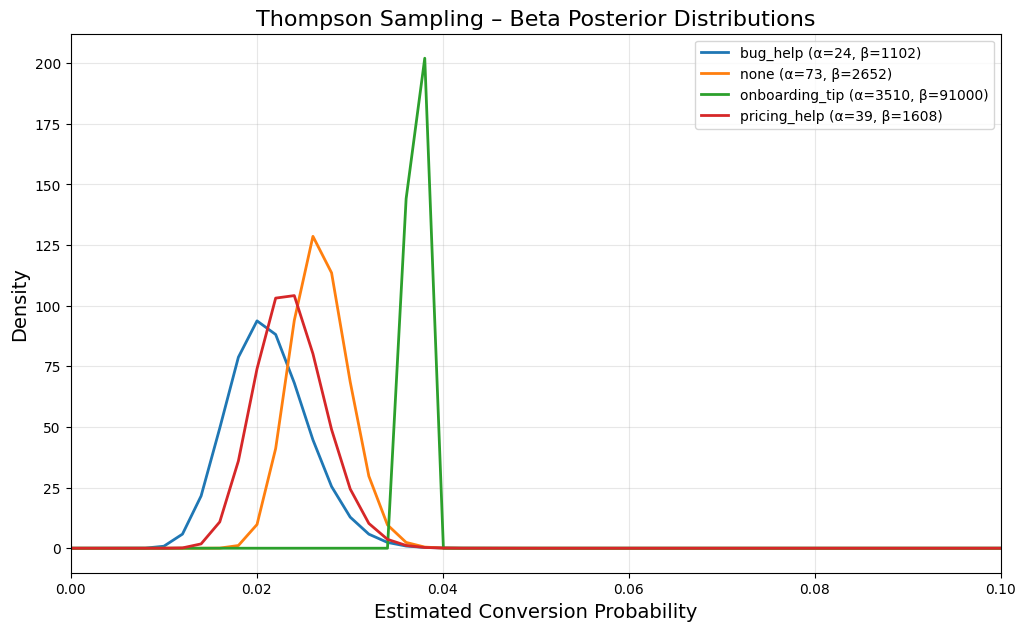

In [27]:
plot_beta_posteriors(alpha_loaded, beta_loaded, ACTIONS)

The posterior will be very sharply peaked, meaning the model believes the conversion rate estimate is very certain.

On the other hand:

bug_help has α=24, β=1102 → likely low conversion, wide distribution

pricing_help has α=39, β=1608 → similar

none has α=73, β=2652 → very low-rate channel as well

This plot will help you see which action dominates in expected reward and how certain the model is.

## Expected CTR per action

In [28]:
expected_ctr = {
    action: alpha_loaded[action] / (alpha_loaded[action] + beta_loaded[action])
    for action in ACTIONS
}

# Display
for action, ctr in expected_ctr.items():
    print(f"{action}: expected CTR = {ctr:.5f}")

bug_help: expected CTR = 0.02131
none: expected CTR = 0.02679
onboarding_tip: expected CTR = 0.03714
pricing_help: expected CTR = 0.02368


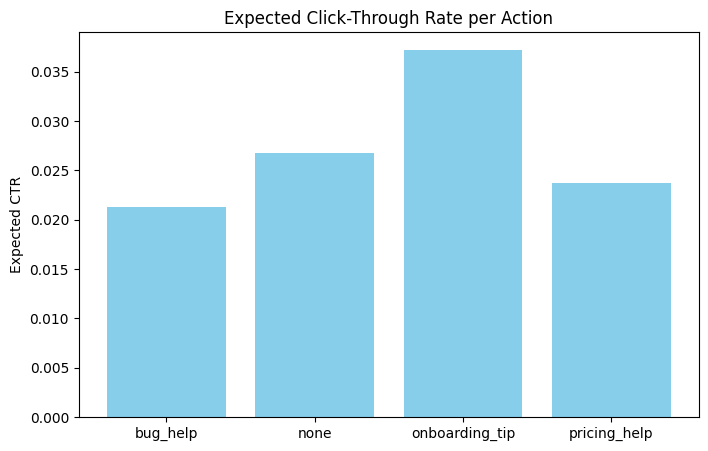

In [29]:
plt.figure(figsize=(8,5))
plt.bar(expected_ctr.keys(), expected_ctr.values(), color='skyblue')
plt.ylabel("Expected CTR")
plt.title("Expected Click-Through Rate per Action")
plt.show()

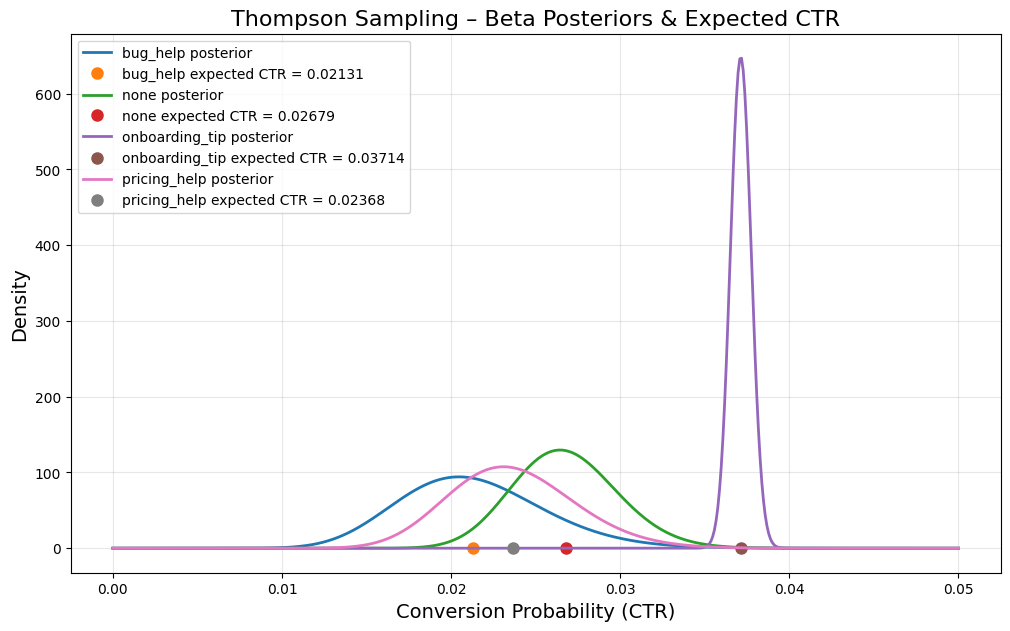

In [ ]:
x = np.linspace(0, 0.05, 500)  # limit x-axis for better visibility

plt.figure(figsize=(12, 7))

# Plot Beta posteriors
for action in ACTIONS:
    a = alpha_loaded[action]
    b = beta_loaded[action]
    y = beta.pdf(x, a, b)
    plt.plot(x, y, linewidth=2, label=f"{action} posterior")
    
    # Plot expected CTR as a marker
    expected_ctr = a / (a + b)
    plt.plot(expected_ctr, 0, 'o', markersize=8, label=f"{action} expected CTR = {expected_ctr:.5f}")

plt.title("Thompson Sampling – Beta Posteriors & Expected CTR", fontsize=16)
plt.xlabel("Conversion Probability (CTR)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()